In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

In [7]:
data_filename  = '../data/v4_annotated/annotated_onion_layer_5_rows_0_to_5000_raters_20.csv'
d_blocked = pd.read_csv(data_filename)
d_blocked = d_blocked.query('_golden == False')

In [32]:
data_filename  = '../data/v4_annotated/annotated_random_data_rows_0_to_5000_raters_20.csv'
d_random = pd.read_csv(data_filename)
d_random = d_random.query('_golden == False')

Say we have 2k human scores for each comment. For each comment, for all (i,j) <= (k+1), spit human scores into 2 non-overlapping sets of I and J of size i and j respectively. Compute correlation between the mean of scores in set I and set J for all comments.
Intuitively, correlation i,j tells us how good i humans are are predicting the labels of another group of j humans.

As i increases, we expect to get better predictions and as j increases, we expect to get more predictable labels.

To figure out how many humans we need to label each question, we should examine the diagonal of the matrix (where i=j) and pick a value of i=j where there are diminishing returns to going further down the diagonal.

To figure out how hard we should try at building a machine learning model for labels that we got from aggregating j_0 human labels we can check the correlations for different values of i. We can interpret correlation (i, j_0) as how good an "ensemble" of i humans is at predicting the labels.

So a model that can achieve correlation (1, j_0) is as good as a single human. Also, we would expect that a model should not beat correlation (j_0, j_0). If it does, then it overfit to the group and you should increase j0.

In [33]:
def get_baseline_matrix(d, k, metric):
    m = k-1
    groups = d[['rev_id',metric]].dropna().groupby('rev_id')
    groups = [e[1] for e in groups if e[1].shape[0]>=k]
    
    print('Num comments with k labels', len(groups))
    
    r = pd.DataFrame(np.zeros((m,m)))
    r.index = r.index +1
    r.columns = r.columns +1

    for i in range(1, m+1):
        for j in range(i, m+1):
            if (i+j) > k:
                continue

            dis = []
            djs = []
            for g in groups:
                if g.shape[0] >= i+j:
                    g = g.iloc[np.random.permutation(len(g))]
                    dis.append(g[0:i])
                    djs.append(g[i:(i+j)])
                else:
                    print(i,j, g, "WARNING: Comment had less than k lablels")

            di =  pd.concat(dis)
            dj = pd.concat(djs)

            scores_i = di.groupby('rev_id')[metric].mean()
            scores_j = dj.groupby('rev_id')[metric].mean()

            r.ix[i,j] = "%0.3f" % pearsonr(scores_i,scores_j )[0]
    return r

In [34]:
metric = 'aggression_score'
k = 20

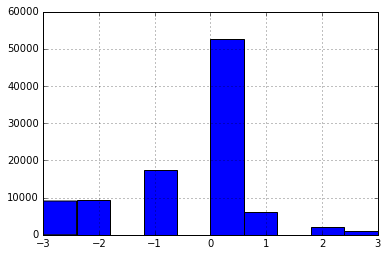

In [35]:
d_blocked['aggression_score'].hist()

In [26]:
get_baseline_matrix(d_blocked, k, metric)

Num comments with k labels 4448


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,0.532,0.607,0.632,0.679,0.696,0.675,0.679,0.690,0.705,0.699,0.691,0.711,0.709,0.715,0.715,0.716,0.713,0.703,0.714
2,0,0.701,0.739,0.757,0.777,0.779,0.773,0.794,0.803,0.799,0.803,0.803,0.807,0.814,0.815,0.811,0.808,0.811,0
3,0,0,0.778,0.789,0.814,0.813,0.834,0.832,0.829,0.844,0.843,0.846,0.853,0.849,0.853,0.857,0.862,0,0
4,0,0,0,0.816,0.841,0.844,0.852,0.858,0.861,0.869,0.870,0.876,0.882,0.881,0.880,0.880,0,0,0
5,0,0,0,0,0.850,0.863,0.872,0.879,0.875,0.887,0.888,0.889,0.892,0.896,0.902,0,0,0,0
6,0,0,0,0,0,0.876,0.880,0.889,0.890,0.894,0.894,0.903,0.904,0.908,0,0,0,0,0
7,0,0,0,0,0,0,0.891,0.895,0.898,0.906,0.911,0.910,0.911,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0.902,0.910,0.907,0.917,0.915,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0.915,0.917,0.919,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0.918,0,0,0,0,0,0,0,0,0


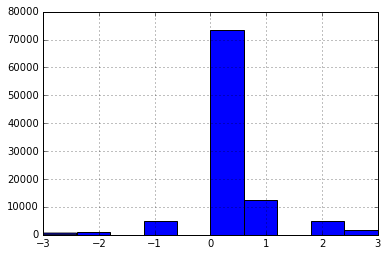

In [36]:
d_random['aggression_score'].hist()

In [37]:
get_baseline_matrix(d_random, k, metric)

Num comments with k labels 4490


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,0.225,0.331,0.347,0.411,0.413,0.436,0.427,0.468,0.427,0.456,0.471,0.447,0.469,0.483,0.486,0.468,0.472,0.473,0.486
2,0,0.405,0.480,0.501,0.532,0.545,0.545,0.569,0.558,0.580,0.574,0.587,0.591,0.590,0.579,0.593,0.595,0.590,0
3,0,0,0.510,0.548,0.560,0.608,0.619,0.606,0.650,0.631,0.641,0.650,0.649,0.653,0.658,0.661,0.666,0,0
4,0,0,0,0.595,0.629,0.651,0.643,0.662,0.669,0.677,0.685,0.696,0.712,0.687,0.709,0.700,0,0,0
5,0,0,0,0,0.627,0.670,0.670,0.700,0.693,0.711,0.730,0.715,0.730,0.742,0.738,0,0,0,0
6,0,0,0,0,0,0.692,0.698,0.701,0.724,0.729,0.741,0.745,0.753,0.751,0,0,0,0,0
7,0,0,0,0,0,0,0.716,0.724,0.740,0.756,0.765,0.764,0.771,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0.750,0.752,0.770,0.769,0.780,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0.763,0.775,0.785,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0.785,0,0,0,0,0,0,0,0,0
